In [15]:
import pandas as pd
import requests
import json
MY_API_KEY = 'e3fd43198781e92e0e07b7f543064003'
univs = {
    'Central European University':60009563,
    'University of Vienna':60025988,
    'New Economic School in Moscow':60027279,
    'University of Warsaw':60013756,
    'Stockholm University':60028378,
    'tilburg University':60017145,
    'KU Leuven':60025063,
    'Charles University':60016605
}

def processLink(sLink,dfs):
    dfs.append(pd.DataFrame(d['entry']))

    
def getAPIresponse(sLink):
    r = requests.get(sLink,headers={'Accept':'application/json','X-ELS-APIKey': MY_API_KEY})
    return r.json()['search-results']
    
def entriesToDF(d,key):
    df = pd.DataFrame(d['entry'])
    df['Institution'] = key
    return df
    
def processQuery(dfs,link,key):   
    d = getAPIresponse(link)
    dfs.append(entriesToDF(d,key))
    
    links = {link['@ref']:link['@href'] for link in d['link']}
    
    if 'next' in links:
        #dfs.append(processLink(links['next']))
        nextLink = links['next']
    else: 
        nextLink = ''
    return dfs,nextLink

def processInst(key):
    nextLink = "http://api.elsevier.com/content/search/scopus?query=AF-ID%28{}%29%20AND%20PUBYEAR%20%3E%202013%20AND%20SUBJAREA%28ECON%29&count=25".format(univs[key])
    
    dfs = []
    while nextLink != '':
        dfs,nextLink = processQuery(dfs,nextLink,key)
    
    return pd.concat(dfs)
    
dfs = []

for key in univs:
    dfs.append(processInst(key))

df = pd.concat(dfs)
df

,@_fa,Institution,affiliation,article-number,citedby-count,dc:creator,dc:identifier,dc:title,eid,link,...,prism:issn,prism:issueIdentifier,prism:pageRange,prism:publicationName,prism:url,prism:volume,pubmed-id,source-id,subtype,subtypeDescription
0,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Közép-Európai ...",NaN,0,Telegdy Á.,SCOPUS_ID:85054175988,Public wage spillovers: The role of individual...,2-s2.0-85054175988,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,09275371,NaN,116-129,Labour Economics,https://api.elsevier.com/content/abstract/scop...,55,NaN,16922,ar,Article
1,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Magyar Tudoman...",NaN,0,Bisztray M.,SCOPUS_ID:85055110703,Learning to import from your peers,2-s2.0-85055110703,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,00221996,NaN,242-258,Journal of International Economics,https://api.elsevier.com/content/abstract/scop...,115,NaN,24393,ar,Article
2,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Közép-Európai ...",NaN,2,Akbar Y.,SCOPUS_ID:85041630932,Disentangling resource and mode escalation in ...,2-s2.0-85041630932,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,10754253,3,257-270,Journal of International Management,https://api.elsevier.com/content/abstract/scop...,24,NaN,20633,ar,Article
3,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Közép-Európai ...",NaN,1,Brown C.,SCOPUS_ID:85047056780,A poor means test? Econometric targeting in Af...,2-s2.0-85047056780,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,03043878,NaN,109-124,Journal of Development Economics,https://api.elsevier.com/content/abstract/scop...,134,NaN,14834,ar,Article
4,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Közép-Európai ...",NaN,0,Békés G.,SCOPUS_ID:85042224182,The ladder of internationalization modes: evid...,2-s2.0-85042224182,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,16102878,3,455-491,Review of World Economics,https://api.elsevier.com/content/abstract/scop...,154,NaN,24230,ar,Article
5,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Pennsylvania S...",NaN,0,Krishna K.,SCOPUS_ID:85044745767,RETAKING IN HIGH STAKES EXAMS: IS LESS MORE?,2-s2.0-85044745767,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,00206598,2,449-477,International Economic Review,https://api.elsevier.com/content/abstract/scop...,59,NaN,23666,ar,Article
6,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Utrecht Univer...",NaN,3,Dijst M.,SCOPUS_ID:85032199285,Exploring urban metabolism—Towards an interdis...,2-s2.0-85032199285,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,09213449,NaN,190-203,"Resources, Conservation and Recycling",https://api.elsevier.com/content/abstract/scop...,132,NaN,26424,ed,Editorial
7,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Közép-Európai ...",NaN,2,Balazsi L.,SCOPUS_ID:84949196401,The estimation of multidimensional fixed effec...,2-s2.0-84949196401,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,07474938,3,212-227,Econometric Reviews,https://api.elsevier.com/content/abstract/scop...,37,NaN,24381,ar,Article
8,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Washington and...",NaN,0,Grajzl P.,SCOPUS_ID:85029909001,"Private enforcement, corruption, and antitrust...",2-s2.0-85029909001,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,01475967,1,20-34,Journal of Comparative Economics,https://api.elsevier.com/content/abstract/scop...,46,NaN,23861,ar,Article
9,true,Central European University,"[{'@_fa': 'true', 'affilname': 'Közép-Európai ...",NaN,0,De Chiara A.,SCOPUS_ID:85039433326,Flexible and mandatory banking supervision,2-s2.0-85039433326,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",...,15723089,NaN,86-104,Journal of Financial Stability,https://api.elsevier.com/content/abstract/scop...,34,NaN,144987,ar,Article


In [67]:
issns = df['prism:issn'].dropna().unique()
l = []
for issn in issns:
    r = requests.get('https://api.elsevier.com/content/serial/title/issn/{}?apiKey=e3fd43198781e92e0e07b7f543064003'.format(issn)).json()
    if 'serial-metadata-response' in r.keys():
        d = r['serial-metadata-response']['entry'][0]
        hasSJR = 'SJRList' in d
        hasSNIP = 'SNIPList' in d
        
        if (hasSJR and hasSNIP):
            l.append({'issn':issn,
                      'SJR':d['SJRList']['SJR'][0]['$'],
                      'SJRyear':d['SJRList']['SJR'][0]['@year'],
                      'SNIP':d['SNIPList']['SNIP'][0]['$'],
                      'SNIPyear':d['SNIPList']['SNIP'][0]['@year']
                     })
        elif (hasSJR and not hasSNIP):
            l.append({'issn':issn,
                      'SJR':d['SJRList']['SJR'][0]['$'],
                      'SJRyear':d['SJRList']['SJR'][0]['@year']
                     })
        elif (hasSNIP and not hasSJR):
            l.append({'issn':issn,
                      'SNIP':d['SNIPList']['SNIP'][0]['$'],
                      'SNIPyear':d['SNIPList']['SNIP'][0]['@year']
                     })


journals = pd.DataFrame(l)
journals

,SJR,SJRyear,SNIP,SNIPyear,issn
0,1.709,2017,1.48,2017,09275371
1,4.149,2017,2.03,2017,00221996
2,1.432,2017,1.432,2017,10754253
3,3.066,2017,2.134,2017,03043878
4,0.795,2017,1.408,2017,16102878
5,3.188,2017,2.003,2017,00206598
6,1.462,2017,2.11,2017,09213449
7,1.797,2017,1.243,2017,07474938
8,0.986,2017,1.313,2017,01475967
9,1.356,2017,1.343,2017,15723089


In [106]:
merged = df.merge(journals,left_on='prism:issn',right_on='issn',how='inner')
merged.SJR = merged.SJR.astype('float64')
merged.SNIP = merged.SNIP.astype('float64')
merged['citedby-count'] = merged['citedby-count'].astype('float64')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def histVar(df,var):
    g = sns.FacetGrid(df,col='Institution', palette='Set1',col_wrap=3) 
    g.map(plt.hist,var,**{'bins':10,'density':True})


# SJR

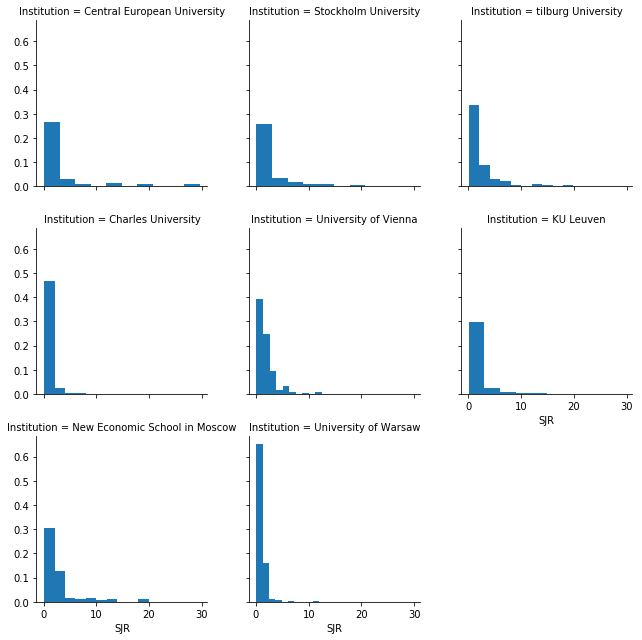

In [107]:
histVar(merged,'SJR')

# SNIP

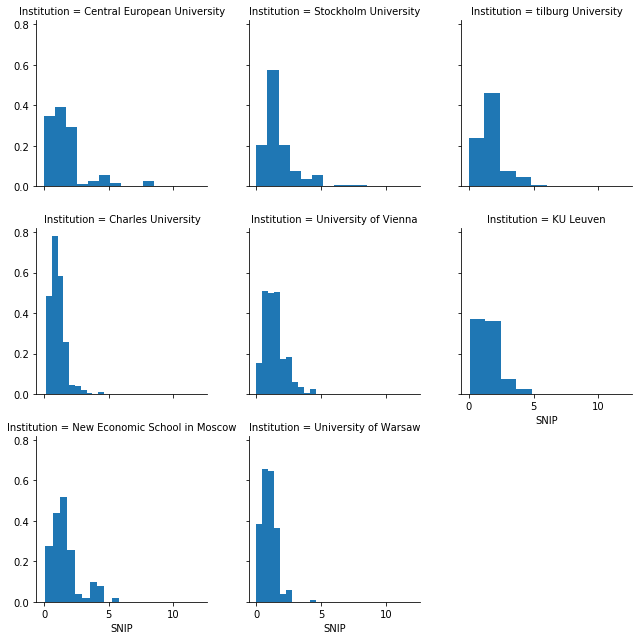

In [108]:
histVar(merged,'SNIP')

# Citations

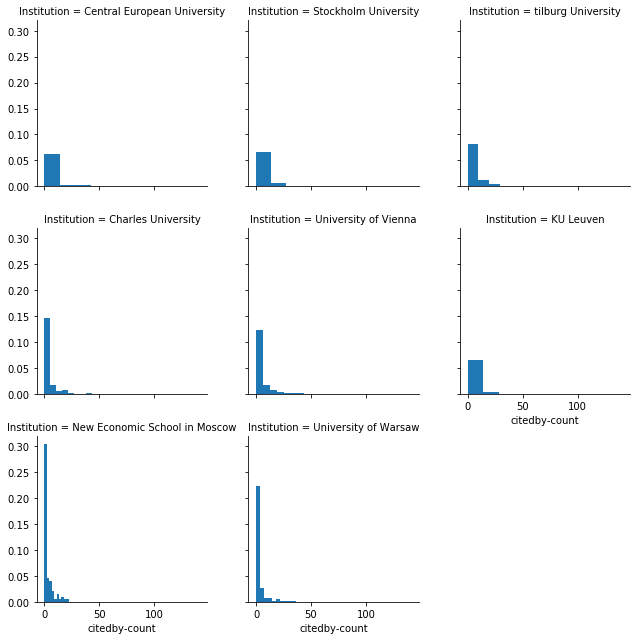

In [109]:
histVar(merged,'citedby-count')

In [89]:
merged.columns

Index(['@_fa', 'Institution', 'affiliation', 'article-number', 'citedby-count',
       'dc:creator', 'dc:identifier', 'dc:title', 'eid', 'link', 'openaccess',
       'openaccessFlag', 'pii', 'prism:aggregationType', 'prism:coverDate',
       'prism:coverDisplayDate', 'prism:doi', 'prism:eIssn', 'prism:isbn',
       'prism:issn', 'prism:issueIdentifier', 'prism:pageRange',
       'prism:publicationName', 'prism:url', 'prism:volume', 'pubmed-id',
       'source-id', 'subtype', 'subtypeDescription', 'SJR', 'SJRyear', 'SNIP',
       'SNIPyear', 'issn'],
      dtype='object')

0       1.709
1       1.709
2       1.709
3       1.709
4       1.709
5       1.709
6       1.709
7       1.709
8       1.709
9       1.709
10      1.709
11      1.709
12      1.709
13      1.709
14      1.709
15      1.709
16      1.709
17      1.709
18      1.709
19      4.149
20      4.149
21      4.149
22      4.149
23      4.149
24      4.149
25      4.149
26      4.149
27      4.149
28      4.149
29      4.149
        ...  
2850    0.431
2851    0.431
2852    0.431
2853    0.221
2854    0.225
2855    0.563
2856    0.563
2857    0.563
2858    0.563
2859    0.563
2860    2.411
2861    2.411
2862    0.386
2863    0.120
2864    0.120
2865    0.120
2866    0.120
2867    0.120
2868    0.120
2869    0.120
2870    0.120
2871    0.113
2872    0.113
2873    0.113
2874    0.154
2875    0.104
2876    0.917
2877    0.583
2878    0.150
2879    0.173
Name: SJR, Length: 2880, dtype: float64

(3684, 29)